In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import os
sys.path.insert(0, '../..')
import laxy
import sw_functions as sw
import network_functions as nf
from sklearn.preprocessing import StandardScaler
#os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/n/helmod/apps/centos7/Core/cuda/10.1.243-fasrc01/"

In [2]:
jax.devices()

[GpuDevice(id=0)]

In [3]:
# chosen hyperparameters 
lr = .05
batch_size = "highest"
iters = "MM"
gradual = "no"
msa_frac = 0.3
msa_memory = 0.9
mode = "EvolveMRF"

o_batch_size = batch_size
if batch_size == "highest":
    batch_sizes = [256, 128, 64]
else:
    batch_sizes = [int(batch_size)]
gap = - 3

basic_pid = [None, None, None, None]
basic_steps = [1, 0, 0, 0]

if gradual == "yes":
    MRF_pid = [1.00, .60, .40, .20]
    init_align_to_msa_frac = 0.0
    init_msa_memory = False

elif gradual == "no":
    MRF_pid = [0, 0, 0, 0]
    init_align_to_msa_frac = msa_frac
    init_msa_memory = msa_memory

if mode =="Standard":
    MRF_steps = [1,0,0,0]
else:
    MRF_steps = [1/4, 1/4, 1/4, 1/4]

basic_steps = [1,0,0,0]
    
if iters == "S":
    basic_steps = [int(2000*_) for _ in basic_steps]
    MRF_steps = [int(1000*_) for _ in MRF_steps]
if iters == "MB":
    basic_steps = [int(2000*_) for _ in basic_steps]
    MRF_steps = [int(2000*_) for _ in MRF_steps]
if iters == "MM":
    basic_steps = [int(3000*_) for _ in basic_steps]
    MRF_steps = [int(1000*_) for _ in MRF_steps]
if iters == "G4":
    basic_steps = [0,0,0,0]
    MRF_steps = [4000, 0, 0, 0]
if iters == "G3":
    basic_steps = [0,0,0,0]
    MRF_steps = [3000, 0, 0, 0]
if iters == "G2":
    basic_steps = [0,0,0,0]
    MRF_steps = [2000, 0, 0, 0]
if iters == "G1":
    basic_steps = [0,0,0,0]
    MRF_steps = [1000, 0, 0, 0]

In [4]:
data = np.load("data_unalign.npz", allow_pickle=True)

In [5]:
np.random.seed(1)
random_family_index = np.random.randint(len(data.keys())-190)+190

In [6]:
for n,x in enumerate(data.keys()):
    if n != random_family_index : continue
    print(f"family {x}")
    a = data[x].item()

family 2HBAA


In [7]:
# prep data
verbose = True
seqs = nf.sub_sample(a["ms"])
lens = np.array([len(seq) for seq in seqs])
ms = nf.one_hot(nf.pad_max(seqs))
aln = nf.one_hot(nf.pad_max(nf.sub_sample(a["aln"])))

if "model" in globals():
    del model
    nf.clear_mem()
for batch_size in batch_sizes:
    print(x)
    try:
        if verbose: print(f"attempting batch size {batch_size}")
        if mode != "Gremlin":
            model = nf.BasicAlign(X=ms, lengths=lens, batch_size=batch_size, filters=512, win=18, 
                       sw_unroll=4, sw_temp=1.0, sw_learn_temp=False,
                       sw_open=None, sw_gap=gap, sw_learn_gap=True,
                       sw_restrict=False,
                       seed=None, lr=lr, norm_mode="fast", 
                       w_scale=0.1)
            if verbose: print("BasicAlign")
            model.fit(basic_steps[0], verbose=verbose)
            msa_params = model.opt.get_params()

            if verbose: print("MRF")

            model = nf.MRF(X=ms, lengths=lens, ss_hide=0.15, batch_size=batch_size, 
                       filters=512, win=18, lam=0.01,
                       sw_unroll=4, sw_temp=1.0, sw_learn_temp=False,
                       sw_open=None, sw_gap=None, sw_learn_gap=False,
                       nat_contacts=a["true"],
                            nat_contacts_mask=a["mask"],
                       nat_aln=None, use_nat_aln=False, add_aln_loss=False, aln_lam=1.0,
                       seed=None, lr=lr, norm_mode="fast",
                       learn_bias=True, w_scale=0.1, 
                       msa_memory = init_msa_memory, align_to_msa_frac = init_align_to_msa_frac, pid_thresh = MRF_pid[0])
            mrf_params = model.opt.get_params()
            for p in ["emb","gap","open"]:
                if p=="gap" and verbose: print(p, msa_params[p])
                mrf_params[p] = msa_params[p]

            model.opt.set_params(mrf_params)
            model.fit(MRF_steps[0], verbose=verbose)

            if mode == "EvolveMRF":
                if verbose: print(f"reset with pid thresh: {MRF_pid[1]}")
                model.reset_model_and_opt({"msa_memory": msa_memory, "align_to_msa_frac": msa_frac, "pid_thresh":MRF_pid[1]})
                model.fit(MRF_steps[1], verbose=verbose)

                if verbose: print(f"reset with pid thresh: {MRF_pid[2]}")
                model.reset_model_and_opt({"msa_memory": msa_memory, "align_to_msa_frac": msa_frac, "pid_thresh":MRF_pid[2]})
                model.fit(MRF_steps[2], verbose=verbose)

                if verbose: print(f"reset with pid thresh: {MRF_pid[3]}")
                model.reset_model_and_opt({"msa_memory": msa_memory, "align_to_msa_frac": msa_frac, "pid_thresh":MRF_pid[3]})
                model.fit(MRF_steps[3], verbose=verbose)

            print("X", mode, x, model.get_auc(), batch_size)


        if mode == "Gremlin":
            if verbose: print("MRF")
            model = nf.MRF(X=ms, lengths=lens, ss_hide=0.15, batch_size=batch_size, 
               filters=512, win=18, lam=0.01,
               sw_unroll=4, sw_temp=1.0, sw_learn_temp=False,
               sw_open=None, sw_gap=None, sw_learn_gap=False,
               nat_contacts=a["true"], nat_contacts_mask=a["mask"],
               nat_aln=jnp.array(aln), use_nat_aln=True, add_aln_loss=False, aln_lam=1.0,
               seed=None, lr=lr, norm_mode="fast",
               learn_bias=True, w_scale=0.1)
            model.fit(MRF_steps[0], verbose=True)

        auc = model.get_auc()
        break
    except Exception as e:
        print("The error raised is: ", e)
    #except:
     #   print(f"FAIL ON {x} with batch size {batch_size}")
      #  auc = None


2ZPTX
attempting batch size 256
BasicAlign
300 5648.443
600 5612.4272
900 5612.3394
1200 5609.2085
1500 5612.855
1800 5620.8945
2100 5616.231
2400 5612.052
2700 5622.375
3000 5610.397
MRF
gap -4.4374557
25 3114.7036 0.07902660498716325
50 2080.3508 0.2670847093248147
75 1877.7318 0.43437321303842014
100 1804.7017 0.5554248476943718
125 1742.3567 0.5957748794609534
150 1703.189 0.6575305130222519
175 1699.7444 0.6621347493656187
200 1700.5867 0.6755005889901385
225 1662.3804 0.6771276475684165
250 1676.3612 0.6950129522279147
reset with pid thresh: 0
25 1683.9459 0.6936612337479507
50 1682.6595 0.6944622910356841
75 1683.8698 0.6905306671040602
100 1656.0984 0.6801001897223634
125 1649.6077 0.6964859421547069
150 1645.574 0.7084090190777838
175 1660.9473 0.710582932121262
200 1647.2797 0.7274719750919594
225 1645.9343 0.7323840578248267
250 1672.8937 0.7404578539474034
reset with pid thresh: 0
25 1678.4065 0.7339897583839362
50 1658.6163 0.720078812698797
75 1643.4528 0.7225378355628417

In [8]:
# 1 where first seq has aa i and other seq has aa j
def get_ij_mask(Z, i, j):
    return jnp.einsum('ij,k->ijk', Z[...,j],Z[0,...,i])

def get_scores(model, ns, aln_only=False):
    aln, sm = model.get_aln(np.array(range(ns)))
    Z = model.X[np.array(range(ns))]
    score_d = {}
    for i in range(20):
        for j in range(20):
            print(i,j)
            mask = get_ij_mask(Z,i,j)
            if aln_only: mask= mask*(aln>0.5)
            if jnp.sum(mask)==0:
                continue
            else:
                K = ((mask*sm)[1:,...]).flatten()
                score_d[(i,j)]= K[K!=0]
    return score_d

In [9]:
ns = 25
score_d = get_scores(model, ns)
score_d_aln = get_scores(model, ns, aln_only = True)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10

In [10]:
all_data = jnp.hstack(score_d.values())
print(all_data.shape)

(63648,)


In [11]:
scaler = StandardScaler()
scaler.fit(all_data.reshape(-1, 1))

StandardScaler()

In [12]:
# BLOSUM62 from https://www.ncbi.nlm.nih.gov/IEB/ToolBox/C_DOC/lxr/source/data/BLOSUM62   
array_as_str = "4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0 -2 -1 -1 -1 -4"\
" -1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3 -1 -2  0 -1 -4"\
" -2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  4 -3  0 -1 -4"\
" -2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  4 -3  1 -1 -4"\
" 0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1 -3 -1 -3 -1 -4"\
" -1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0 -2  4 -1 -4"\
" -1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  1 -3  4 -1 -4"\
" 0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3 -1 -4 -2 -1 -4"\
" -2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0 -3  0 -1 -4"\
" -1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3 -3  3 -3 -1 -4"\
" -1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1 -4  3 -3 -1 -4"\
" -1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0 -3  1 -1 -4"\
" -1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1 -3  2 -1 -1 -4"\
" -2 -3 -3 -3 -2 -3 -3 -3 -1  0  0 -3  0  6 -4 -2 -2  1  3 -1 -3  0 -3 -1 -4"\
" -1 -2 -2 -1 -3 -1 -1 -2 -2 -3 -3 -1 -2 -4  7 -1 -1 -4 -3 -2 -2 -3 -1 -1 -4"\
" 1 -1  1  0 -1  0  0  0 -1 -2 -2  0 -1 -2 -1  4  1 -3 -2 -2  0 -2  0 -1 -4"\
" 0 -1  0 -1 -1 -1 -1 -2 -2 -1 -1 -1 -1 -2 -1  1  5 -2 -2  0 -1 -1 -1 -1 -4"\
" -3 -3 -4 -4 -2 -2 -3 -2 -2 -3 -2 -3 -1  1 -4 -3 -2 11  2 -3 -4 -2 -2 -1 -4"\
" -2 -2 -2 -3 -2 -1 -2 -3  2 -1 -1 -2 -1  3 -3 -2 -2  2  7 -1 -3 -1 -2 -1 -4"\
" 0 -3 -3 -3 -1 -2 -2 -3 -3  3  1 -2  1 -1 -2 -2  0 -3 -1  4 -3  2 -2 -1 -4"\
" -2 -1  4  4 -3  0  1 -1  0 -3 -4  0 -3 -3 -2  0 -1 -4 -3 -3  4 -3  0 -1 -4"\
" -1 -2 -3 -3 -1 -2 -3 -4 -3  3  3 -3  2  0 -3 -2 -1 -2 -1  2 -3  3 -3 -1 -4"\
" -1  0  0  1 -3  4  4 -2  0 -3 -3  1 -1 -3 -1  0 -1 -2 -2 -2  0 -3  4 -1 -4"\
" -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -4"\
" -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4  1"\

In [13]:
BLOSUM_array=np.array([int(_) for _ in array_as_str.split(" ") if _ !='']).reshape((25,25))
aa_s=[_ for _ in "A  R  N  D  C  Q  E  G  H  I  L  K  M  F  P  S  T  W  Y  V  B  J  Z  X  *".split(" ") if _ !=''] 


BLOSUM_d={}
for n1, aa1 in enumerate(aa_s):
    for n2, aa2 in enumerate(aa_s):
         BLOSUM_d[(aa1, aa2)]=BLOSUM_array[n1,n2]

num_to_aa = {}
num_to_aa[-1] = "-"
for n, ch in enumerate("ARNDCQEGHILKMFPSTWYV-"): #SMURF data one-hot encoding
    num_to_aa[n] = ch



In [14]:
Z = model.X[np.array(range(ns))]
icounts = jnp.sum(Z[0,...], axis = 0)
jcounts = jnp.sum(Z[1:,...], axis = [0,1])


In [15]:
b_score_d = {}
for i in range(20):
    for j in range(20):
        b_score_d[(i,j)]=jnp.ones(int(icounts[i].item()*jcounts[j].item()))*BLOSUM_d[(num_to_aa[i], num_to_aa[j])]

In [16]:
b_all_data = jnp.hstack(b_score_d.values())
print(b_all_data.shape)

(63648,)


In [17]:
b_scaler = StandardScaler()
b_scaler.fit(b_all_data.reshape(-1, 1))

StandardScaler()

In [19]:
use = []
for i in range(20):
    if icounts[i]>3 or jcounts[i] > 3*ns:
        use.append(i)

In [20]:
plt.rc('font', size=14) #controls default text size

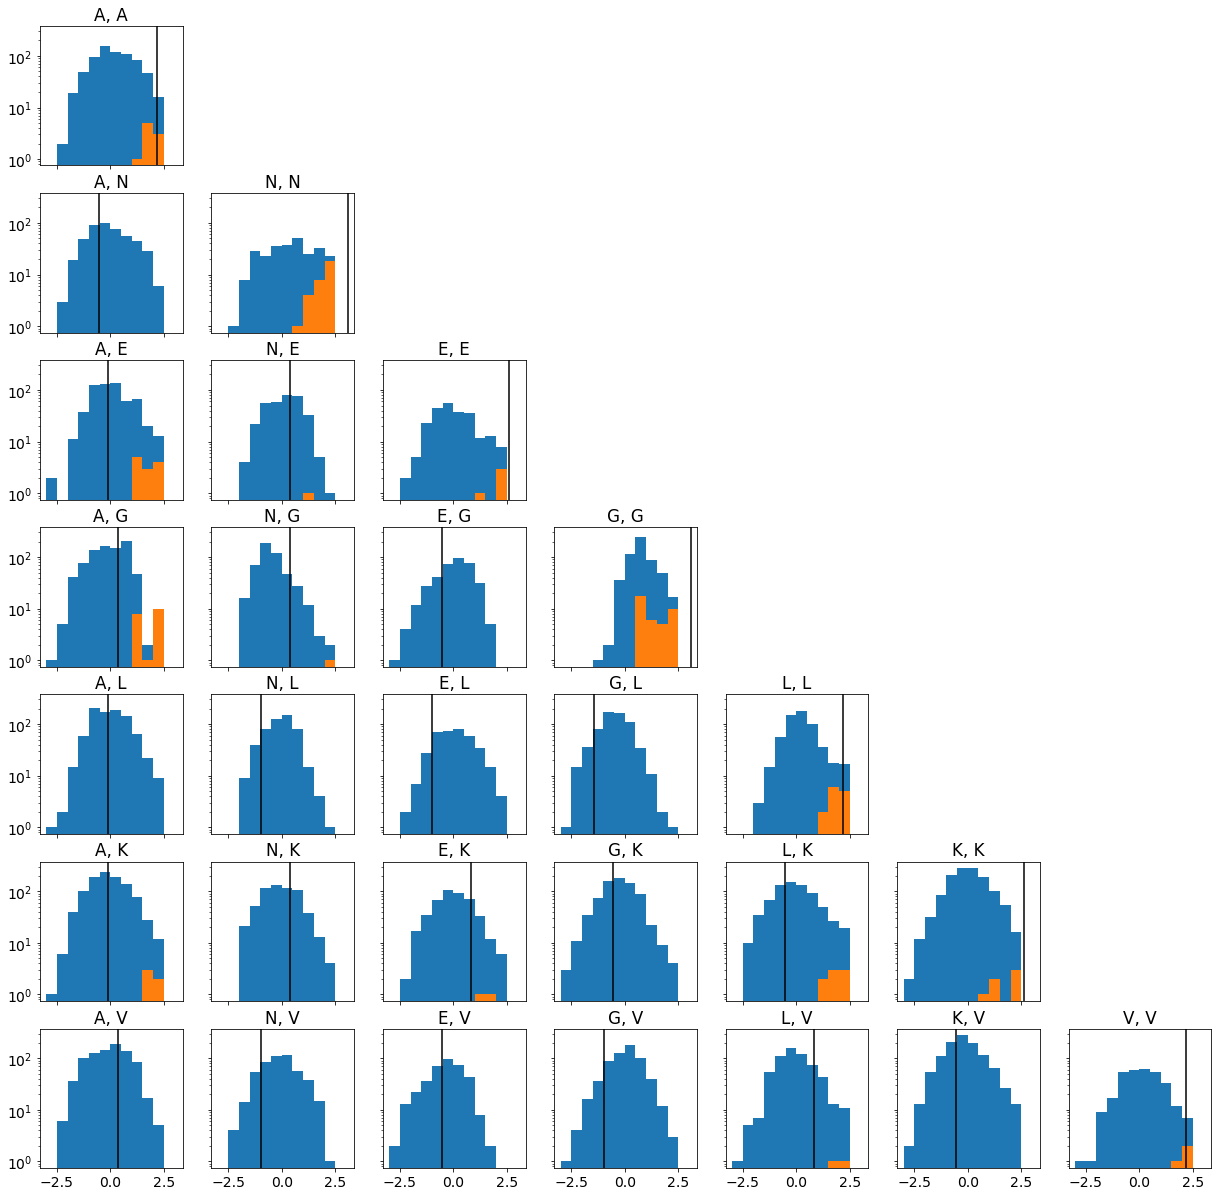

In [26]:
minn = -3
maxx = 3
L = len(use)
f, ax = plt.subplots(L,L, figsize = (3*L,3*L), sharey=True, sharex=True)
for idx, i in enumerate(use):
    for idxj, j in enumerate(use):
        if idx> idxj: 
            ax[idxj, idx].axis('off')
            continue
        if (i,j) in score_d.keys():
            vals_all = [_[0] for _ in scaler.transform(score_d[(i,j)].reshape(-1, 1))]
            if (i,j) in score_d_aln.keys():
                vals_aln = [_[0] for _ in scaler.transform(score_d_aln[(i,j)].reshape(-1, 1))]
            else:
                vals_aln = []
        #ax[idxj,idx].hist([vals_all, vals_aln], bins = np.arange(minn, maxx, .5), histtype='barstacked' )
        ax[idxj,idx].hist(vals_all, bins = np.arange(minn, maxx, .5))
        ax[idxj,idx].hist(vals_aln, bins = np.arange(minn, maxx, .5))
        ax[idxj,idx].axvline(b_scaler.transform(np.array(BLOSUM_d[(num_to_aa[i], num_to_aa[j])]).reshape(-1,1)), color='black')
        ax[idxj,idx].set_title(f"{num_to_aa[i]}, {num_to_aa[j]}")
        ax[idxj,idx].set_yscale("log")
f.savefig("scores_compare.pdf")
